# Top6

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import sys
from time import time
import numpy as np
import pandas as pd

import sklearn
from collections import OrderedDict
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SEED = 42

In [2]:
# Top6 from Rick
# datadir = Path('../data/processed/topN/topNrick/')
# datapath = datadir/'uniq.top6.reg.parquet'

# Top6 from code
datadir = Path('../data/processed/topN/topNcode/')
datapath = datadir/'top_6.res_reg.cf_rnaseq.dd_dragon7.labled.parquet'

# Create mini Top6

In [3]:
# data = pd.read_parquet(datapath, engine='auto', columns=None)
# data = data.sample(frac=1.0, axis=0, random_state=SEED).reset_index(drop=True)
# print(data.shape)

# col_idx = data.nunique(dropna=True).values == 1  # col indexes to drop
# data = data.iloc[:, ~col_idx]
# print(data.shape)

# def subset(data, s):
#     if s <= 1.0:
#         data_size = int(data.shape[0]*s)
#     return data[:data_size]

# data = subset(data, s=0.3)
# print(data.shape)
# # data.to_csv(datadir/'uniq.top6.reg.mini.csv', index=False)
# data.to_parquet(datadir/'uniq.top6.reg.mini.parquet', index=False)

# display(data[:3])

# Load and pre-process

In [4]:
# Load data
# data = pd.read_csv(datadir/'uniq.top6.reg.mini.csv')
data = pd.read_parquet(datadir/'uniq.top6.reg.mini.parquet')
print(data.shape)

if 'topNcode' in str(datadir):
    data.drop(columns=['CELL', 'DRUG'], inplace=True)

(85501, 3763)


In [5]:
# Split train/test
df_tr, df_te = train_test_split(data, test_size=0.2)
df_tr = df_tr.reset_index(drop=True)
df_te = df_te.reset_index(drop=True)
print(df_tr.shape)
print(df_te.shape)

# Split features/target
ytr, xtr = df_tr.iloc[:,0], df_tr.iloc[:,1:]
yte, xte = df_te.iloc[:,0], df_te.iloc[:,1:]

del data, df_tr, df_te

(68400, 3761)
(17101, 3761)


In [6]:
# Scale
col_names = xtr.columns

scaler = StandardScaler()
xtr = pd.DataFrame( scaler.fit_transform(xtr) ).astype(np.float32)
xte = pd.DataFrame( scaler.transform(xte) ).astype(np.float32)

xtr.columns = col_names
xte.columns = col_names

print(xtr.shape)
print(xte.shape)
print(ytr.shape)
print(yte.shape)

(68400, 3760)
(17101, 3760)
(68400,)
(17101,)


# PyTorch
https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb

In [7]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)

1.1.0


In [8]:
x =  torch.Tensor([[1, 2, 3], [1, 2, 3]]).view(-1, 2)
y =  torch.Tensor([[2, 1]]).view(2, -1)

print('x.shape', x.shape)
print('y.shape', y.shape)

print('\nx\n', x)
print('\ny\n', y)
print('\nx * y\n', torch.mm(x, y))

x.shape torch.Size([3, 2])
y.shape torch.Size([2, 1])

x
 tensor([[1., 2.],
        [3., 1.],
        [2., 3.]])

y
 tensor([[2.],
        [1.]])

x * y
 tensor([[4.],
        [7.],
        [7.]])


In [9]:
# # Convert pandas df to torch tensors
# def np_to_tensor(a, dtype=torch.float32):
#     """ Convert np arr to tensor. """
#     return torch.tensor(a, dtype=dtype)

# # xtr, ytr, xte, yte = map(np_to_tensor, (xtr.values, ytr.values, xte.values, yte.values))

# xtr = np_to_tensor(xtr.values, dtype=torch.float32)
# ytr = np_to_tensor(ytr.values, dtype=torch.float32)
# xte = np_to_tensor(xte.values, dtype=torch.float32)
# yte = np_to_tensor(yte.values, dtype=torch.float32)

# print(type(xtr))
# print(xtr.dtype)

# Dataset

In [10]:
class Top6Dataset(Dataset):
    # discuss.pytorch.org/t/data-processing-as-a-batch-way/14154
    # github.com/utkuozbulak/pytorch-custom-dataset-examples#incorporating-pandas
    # nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb
    def __init__(self,
                 xdata: pd.DataFrame,
                 ydata: pd.DataFrame):
        # xdata and ydata are pandas dfs
        xdata = pd.DataFrame(xdata).values
        ydata = pd.DataFrame(ydata).values
        self.x = torch.tensor(xdata, dtype=torch.float32)
        self.y = torch.tensor(ydata, dtype=torch.float32)
        self.y = self.y.view(-1, 1)
        
        # xdata and ydata are torch tensors
        #self.x = xdata
        #self.y = ydata
        #self.y = self.y.view(-1, 1)        
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        x = self.x[idx, :]
        y = self.y[idx]
        return x, y

In [11]:
tr_ds = Top6Dataset(xdata=xtr, ydata=ytr)
vl_ds = Top6Dataset(xdata=xte, ydata=yte)

# Dataloaders

In [12]:
# Define data loaders
batch_size = 32
num_workers = 1
tr_loader_kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
vl_loader_kwargs = {'batch_size': 4*batch_size, 'shuffle': False, 'num_workers': num_workers}

tr_loader = DataLoader(tr_ds, **tr_loader_kwargs)
vl_loader = DataLoader(vl_ds, **vl_loader_kwargs)

In [13]:
# xb, yb = next(iter(tr_loader))
# print(xb.shape)
# print(yb.shape)
# print(xb[:2])
# print(yb[:2])

# Network

In [14]:
class NN_REG(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 250)
        self.fc5 = nn.Linear(250, 125)
        self.fc6 = nn.Linear(125, 60)
        self.fc7 = nn.Linear(60, 30)
        self.fc8 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.dropout(F.relu(self.fc6(x)))
        x = self.dropout(F.relu(self.fc7(x)))
        x = F.relu(self.fc8(x))
        return x

In [15]:
class NN_REG(nn.Module):
    def __init__(self, input_dim, dr_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 60)
        self.fc5 = nn.Linear(60, 1)
        self.dropout = nn.Dropout(dr_rate)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.relu(self.fc5(x))
        return x

In [16]:
def weight_init_linear(m: nn.Module):
    # Weight initialization
    """
    Pytorch initializes the layers by default (e.g., Linear uses kaiming_uniform_)
    www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/
    stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    github.com/xduan7/UnoPytorch/blob/master/networks/initialization/weight_init.py
    """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# Model to CUDA

In [17]:
def get_model_device(model):
    return str(next(model.parameters()).device)

In [18]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
# print(device)

In [19]:
# pytorch.org/docs/stable/cuda.html
# towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051
print('is_available:  ', torch.cuda.is_available())
print('device_name:   ', torch.cuda.get_device_name(0))
print('device_count:  ', torch.cuda.device_count())
print('current_device:', torch.cuda.current_device())

is_available:   True
device_name:    GeForce RTX 2080 Ti
device_count:   4
current_device: 0


In [20]:
# Choose device
device = torch.device('cuda:3')

# Move model to CUDA device
model = NN_REG(input_dim=tr_ds.x.shape[1]).to(device) # send model to gpu/cpu device
model.apply(weight_init_linear)

# Query device where the model is located
print(get_model_device(model))
print('current_device:', torch.cuda.current_device()) # why current device is 0??

cuda:3
current_device: 0


In [21]:
# if device.type == 'cuda':
#     print(get_model_device(model))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3, 1), 'GB')

In [22]:
# # Choose cuda device with context manager
# with torch.cuda.device(2):
#     print('\ncurrent_device:', torch.cuda.current_device())
#     model = NN_REG(input_dim=tr_ds.x.shape[1]).to(device=device)
# print('current_device:', torch.cuda.current_device())

# Loss function and optimizer

In [23]:
loss_fnc = nn.MSELoss(reduction='mean')
opt = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)  # pytorch.org/docs/stable/optim.html
# lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=opt, base_lr=1e-5, max_lr=1e-3, mode='triangular')

### Try a single training iteration

In [24]:
xx, yy = next(iter(tr_loader))
xx = xx.to(device)
yy = yy.to(device)
print(xx.device)
print(yy.device)

# Forward
opt.zero_grad()
pred = model(xx)

print(f'pred.shape {pred.shape}')
print(f'yb.shape {yy.shape}')
yy = yy.view(pred.shape)
print(f'yb.shape {yy.shape}\n')

print('pred:\n', pred[:3])
print('yy:\n', yy[:3])
pred = pred.type(torch.float32)
print('pred:\n', pred[:3])

# Backprop
loss = loss_fnc(pred, yy)
loss.backward() # compute loss gradients wrt to model parameters and inputs
opt.step()      # update model parameters;  pytorch.org/docs/stable/optim.html

cuda:3
cuda:3
pred.shape torch.Size([32, 1])
yb.shape torch.Size([32, 1])
yb.shape torch.Size([32, 1])

pred:
 tensor([[0.4251],
        [0.4424],
        [0.0000]], device='cuda:3', grad_fn=<SliceBackward>)
yy:
 tensor([[1.0000],
        [0.9567],
        [0.9802]], device='cuda:3')
pred:
 tensor([[0.4251],
        [0.4424],
        [0.0000]], device='cuda:3', grad_fn=<SliceBackward>)


In [25]:
# print(f'pred.shape {pred.shape}')
# print(f'yb.shape   {yb.shape}\n')
# mae = torch.abs(pred - yb)
# r2_torch(y_true=yb, y_pred=pred)

## Training loop

In [26]:
# discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
# groups.google.com/forum/#!topic/torch7/CkB57025yRY
# torch.backends.cudnn.benchmark = True

In [27]:
def r2_torch(y_true, y_pred):
    epsilon = 1e-7  # this epsilon value used in TF
    SS_res = torch.sum( (y_true - y_pred)**2 )
    SS_tot = torch.sum( (y_true - torch.mean(y_true))**2 )
    r2 = 1 - SS_res / (SS_tot + epsilon)
    return r2

In [28]:
# def calc_reg_scores(pred, true, metrics, val=False):
#     prfx = 'val_' if val is True else '' 
#     scores = {}
    
#     for m in metrics:
#         if 'loss' in m:
#             continue
            
#         elif m in ['mean_abs_err', 'mean_absolute_error']:
#             scores[prfx + 'mean_abs_err'] = torch.mean(torch.abs(pred-true))

#         elif m in ['median_abs_err', 'median_absolute_error']:
#             scores[prfx + 'median_abs_err'] = torch.median(torch.abs(pred-true))

#         elif m in ['mean_sqrd_err', 'mean_squared_error']:
#             scores[prfx + 'mean_sqrd_err'] = torch.mean(torch.pow(pred-true, 0.5))  # or torch.mean(torch.sqrt(pred-true))
            
#         elif m in ['r2', 'r2_score']:
#             scores[prfx + 'r2'] = r2_torch(y_true=true, y_pred=pred)
            
#     return scores

In [29]:
def update_scores_reg(pred, true, scores):
    """ Updates score metrics for regression ML predictions.
    The scores are summed for every call of the function (single func call corresponds a single batch).
    
    Note: these must be implemented with pytroch commands! Otherwise, results gives error:
    RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.   
    pred, true = pred.numpy(), yy.numpy()
    tr_mae += sklearn.metrics.mean_absolute_error(true, pred)
    tr_r2 += sklearn.metrics.r2_score(true, pred)
    """
    for m in scores.keys():
        if 'loss' in m:
            continue
            
        elif any([True if v in m else False for v in ['mean_abs_err', 'mean_absolute_error']]):
            scores[m] += torch.mean( torch.abs(pred-true) ).item()

        elif any([True if v in m else False for v in ['median_abs_err', 'median_absolute_error']]):
            scores[m] += torch.median( torch.abs(pred-true) ).item()

        elif any([True if v in m else False for v in ['mean_sqrd_err', 'mean_squared_error']]):
            scores[m] += torch.mean( torch.pow(pred-true, 0.5) ).item()  # or torch.mean(torch.sqrt(pred-true))
            
        elif any([True if v in m else False for v in ['r2', 'r2_score']]):
            scores[m] += r2_torch(y_true=true, y_pred=pred).item()
            
    return scores

In [30]:
# def proc_batch(xx, yy, model, loss_fnc, opt=None):
def proc_batch(xx_dct, yy, model, loss_fnc, opt=None):
    """ 
    Args:
        opt (torch.optim) : no backprop is performed if optimizer is not provided (for val or test) 
    """
    # pred = model(xx)
    # loss = loss_fnc(pred, yy)
    
    pred = model(**xx_dct)
    pred = pred.type(yy.dtype)
    loss = loss_fnc(pred, yy)
    
    # Backward pass
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss, pred

In [33]:
def fit(model: nn.Module,
        loss_fnc,
        opt: torch.optim,
        tr_dl: torch.utils.data.DataLoader,
        vl_dl: torch.utils.data.DataLoader=None,
        epochs: int=1,
        device: torch.device='cuda:0',
        verbose: bool=True,
        metrics=[]) -> dict:
    """ github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
    Args:
        metrics (list) : list of metric scores to log
            (available metrics: 'mean_abs_err','median_abs_err', 'mean_sqrd_err', 'r2)
    """ 
    print(f'Arg `device`: {device}')
    model.to(device)
    print('current_device:', torch.cuda.current_device())
    
    # Choose cuda device with context manager --> try using context manager!!!
    # with torch.cuda.device(device):
        
    # Create dicts to log scores
    if vl_dl is None:
        logs = OrderedDict({'loss': []})
        logs.update(OrderedDict({m: [] for m in metrics}))        
    else:
        logs = OrderedDict({'loss': [], 'val_loss': []})
        for m in metrics: logs.update(OrderedDict({m: [], 'val_'+m: []}))
    
    # Iter over epochs
    phases = ['train', 'val'] if vl_dl is not None else ['train']
    for ep in range(epochs):
        ep_t0 = time()
        # lr_scheduler.step()
        
        for ph in phases:
            if ph == 'train':
                model.train()
                dl = tr_dl
                scores = {m: 0 for m in logs.keys() if 'val' not in m}
                loss_name = 'loss'
            elif ph == 'val':
                model.eval()
                dl = vl_dl
                scores = {m: 0 for m in logs.keys() if 'val' in m}
                loss_name = 'val_loss'

            # Iter over batches
            for xx, yy in dl:
                yy = yy.to(device)
                xx = xx.to(device)
                xx_dct = {'x': xx} # new
                
                # Process batch
                if ph == 'train':
                    # loss, pred = proc_batch(xx, yy, model=model, loss_fnc=loss_fnc, opt=opt) # new
                    loss, pred = proc_batch(xx_dct, yy, model=model, loss_fnc=loss_fnc, opt=opt) # new
                else:
                    # loss, pred = proc_batch(xx, yy, model=model, loss_fnc=loss_fnc, opt=None) # new
                    loss, pred = proc_batch(xx_dct, yy, model=model, loss_fnc=loss_fnc, opt=None) # new

                # Compute metrics (running avg)
                scores[loss_name] += loss.item()
                scores = update_scores_reg(pred=pred, true=yy, scores=scores)
            
            # Log scores
            for m in scores.keys():
                logs[m].append(scores[m]/len(dl))
            
        del xx, yy, loss, pred, scores
        
        if verbose:
            print(f'Epoch {ep+1}/{epochs}; ',
                  f'{int(time()-ep_t0)}s; ',
                  [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])
            
        # TODO: log scores into file

    return logs

In [35]:
epochs = 30
metrics = ['mean_abs_err', 'r2']
verbose = True
fit_kwargs = {'epochs': epochs, 'device': device, 'verbose': verbose, 'metrics': metrics}

logs = fit(model=model,
           loss_fnc=loss_fnc,
           opt=opt,
           tr_dl=tr_loader,
           vl_dl=vl_loader,
           **fit_kwargs)

Arg `device`: cuda:3
current_device: 0
Epoch 1/30;  7s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.093', 'val_mean_abs_err: 0.092', 'r2: 0.259', 'val_r2: 0.355']
Epoch 2/30;  8s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.093', 'val_mean_abs_err: 0.091', 'r2: 0.258', 'val_r2: 0.361']
Epoch 3/30;  7s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.092', 'val_mean_abs_err: 0.090', 'r2: 0.263', 'val_r2: 0.365']
Epoch 4/30;  8s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.092', 'val_mean_abs_err: 0.091', 'r2: 0.269', 'val_r2: 0.364']
Epoch 5/30;  8s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.092', 'val_mean_abs_err: 0.088', 'r2: 0.267', 'val_r2: 0.376']
Epoch 6/30;  7s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.092', 'val_mean_abs_err: 0.089', 'r2: 0.270', 'val_r2: 0.374']
Epoch 7/30;  7s;  ['loss: 0.015', 'val_loss: 0.014', 'mean_abs_err: 0.092', 'val_mean_abs_err: 0.090', 'r2: 0.272', 'val_r2: 0.369']
Epoch 8/30;  7s;  ['loss: 0.01

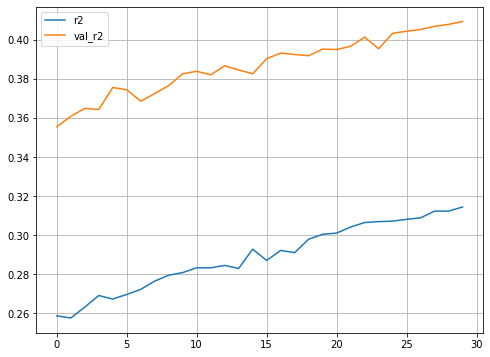

In [36]:
plt.figure(figsize=(8,6))

# plt.plot(logs['loss'], label='loss');
# plt.plot(logs['val_loss'], label='val_loss');
# plt.legend(loc='best');

# plt.plot(logs['mean_abs_err'], label='mean_abs_err');
# plt.plot(logs['val_mean_abs_err'], label='val_mean_abs_err');
# plt.legend(loc='best');

plt.plot(logs['r2'], label='r2');
plt.plot(logs['val_r2'], label='val_r2');
plt.legend(loc='best');

plt.legend(loc='best')
plt.grid(True)

In [54]:
# def fit(model: nn.Module,
#         loss_fnc,
#         opt: torch.optim,
#         tr_dl: torch.utils.data.DataLoader,
#         vl_dl: torch.utils.data.DataLoader=None,
#         epochs: int=1,
#         device: torch.device='cuda:0',
#         verbose: bool=True,
#         metrics=[]) -> dict:
#     """ github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
#     Args:
#         metrics (list) : list of metric scores to log
#             (available metrics: 'mean_abs_err','median_abs_err', 'mean_sqrd_err', 'r2)
#     """ 
#     print(f'Arg `device`: {device}')
#     model.to(device)
#     print('current_device:', torch.cuda.current_device())
    
#     # Choose cuda device with context manager --> try using context manager!!!
#     # with torch.cuda.device(device):
        
#     # Create dicts to log scores
#     if vl_dl is None:
#         logs = OrderedDict({'loss': []})
#         logs.update(OrderedDict({m: [] for m in metrics}))        
#     else:
#         logs = OrderedDict({'loss': [], 'val_loss': []})
#         for m in metrics: logs.update(OrderedDict({m: [], 'val_'+m: []}))
    
#     # Iter over epochs
#     phases = ['train', 'val'] if vl_dl is not None else ['train']
#     for ep in range(epochs):
#         ep_t0 = time()
        
#         # -------------
#         # Training loop
#         # -------------
#         model.train() # turns-on dropout for training
#         tr_scores = {m: 0 for m in logs.keys() if 'val' not in m}
        
#         for xx, yy in tr_dl:
#             xx = xx.to(device)
#             yy = yy.to(device)
            
#             # Process batch
#             loss, pred = proc_batch(xx, yy, model, loss_fnc, opt=opt)
                  
#             # Compute metrics (running avg)
#             tr_scores['loss'] += loss.item()
#             tr_scores = update_scores_reg(pred=pred, true=yy, scores=tr_scores)
                
#         for m in tr_scores.keys():
#             print(m)
#             logs[m].append(tr_scores[m]/len(tr_dl))
                
#         del xx, yy, loss, pred, tr_scores
                
#         # ---------------
#         # Validation loop
#         # ---------------        
#         if vl_dl is not None:
#             model.eval()  # turn-off dropout in inferenece
#             vl_scores = {m: 0 for m in logs.keys() if 'val' in m}
            
#             with torch.no_grad():
#                 for xx, yy in vl_dl:
#                     xx = xx.to(device)
#                     yy = yy.to(device)
                    
#                     # Process batch
#                     loss, pred = proc_batch(xx, yy, model, loss_fnc, opt=None)
                                
#                     # Compute metrics at the end of each epoch (not the running avg across the batches)
#                     vl_scores['val_loss'] += loss.item()
#                     vl_scores = update_scores_reg(pred=pred, true=yy, scores=vl_scores)
                        
#                 # Update logs
#                 for m in vl_scores.keys():
#                     print(m)
#                     logs[m].append(vl_scores[m]/len(vl_dl))
        
#                 del xx, yy, loss, pred, vl_scores
        
#         if verbose:
#             print(f'Epoch {ep+1}/{epochs}; ',
#                   f'{int(time()-ep_t0)}s; ',
#                   [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])
#     return logs

In [ ]:
# verbose = True
# epochs = 10
# logs = OrderedDict({'loss': [], 'val_loss': [],
#                     'mean_abs_err': [], 'val_mean_abs_err': [],
#                     'r2': [], 'val_r2': []})

# # Choose cuda device with context manager
# with torch.cuda.device(device):
#     print('\ncurrent_device:', torch.cuda.current_device())
    
#     for ep in range(epochs):
#         ep_t0 = time()
        
#         # -------------
#         # Training loop
#         # -------------
#         model.train() # turns-on dropout for training
#         tr_loss, tr_mae, tr_r2 = 0, 0, 0

#         for xx, yy in tr_loader:
#             xx = xx.to(device) # move data to gpu/cpu device
#             yy = yy.to(device) # move data to gpu/cpu device
            
#             # Feedforward
#             pred = model(xx)
#             loss = loss_fnc(pred, yy)

#             # Backprop and optimization
#             opt.zero_grad()
#             loss.backward()   # compute loss gradients wrt to model parameters and inputs
#             opt.step()  # update model parameters;  pytorch.org/docs/stable/optim.html
            
#             # Compute metrics
#             tr_loss += loss.item() # item() returns a number from a tensor that contains a single value
#             tr_mae += torch.mean(torch.abs(pred-yy))
#             tr_r2 += r2_torch(y_true=yy, y_pred=pred)

#         tr_loss /= len(tr_loader)
#         tr_mae /= len(tr_loader)
#         tr_r2 /= len(tr_loader)
        
#         logs['loss'].append(tr_loss)
#         logs['mae'].append(tr_mae)
#         logs['r2'].append(tr_r2)

#         del xx, yy

#         # ---------------
#         # Validation loop
#         # ---------------
#         if vl_loader is not None:
#             model.eval()  # turn-off dropout in inferenece
#             with torch.no_grad():
#                 vl_loss, vl_mae, vl_r2 = 0, 0, 0

#                 for xx, yy in vl_loader:
#                     xx = xx.to(device)
#                     yy = yy.to(device)

#                     # Feedforward
#                     pred = model(xx)
#                     loss = loss_fnc(pred, yy)

#                     # Compute metrics
#                     vl_loss += loss.item() # item() returns a number from a tensor that contains a single value
#                     vl_mae += torch.mean(torch.abs(pred-yy))
#                     vl_r2 += r2_torch(y_true=yy, y_pred=pred)

#                 vl_loss /= len(vl_loader)
#                 vl_mae /= len(vl_loader)
#                 vl_r2 /= len(vl_loader)

#                 logs['val_loss'].append(vl_loss)
#                 logs['val_mae'].append(vl_mae)
#                 logs['val_r2'].append(vl_r2)

#                 del xx, yy

# #         if verbose:
# #             print(f'Epoch {ep+1}/{epochs}; ',
# #                   f'{int(time()-t0)}s; '
# #                   f'tr_loss: {tr_loss:.3f}; ',
# #                   f'vl_loss: {vl_loss:.3f}; ',
# #                   f'tr_mae: {tr_mae:.3f}; ',
# #                   f'vl_mae: {vl_mae:.3f}; ',
# #                   f'tr_r2: {tr_r2:.3f}; ',
# #                   f'vl_r2: {vl_r2:.3f}; ')
            
#         if verbose:
#             print(f'Epoch {ep+1}/{epochs}; ',
#                   f'{int(time()-ep_t0)}s; ',
#                   [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])